Histograms in output: dict_keys(['selectedmuons_p', 'fourmuons_mass'])
fourmuons_mass hist entries: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


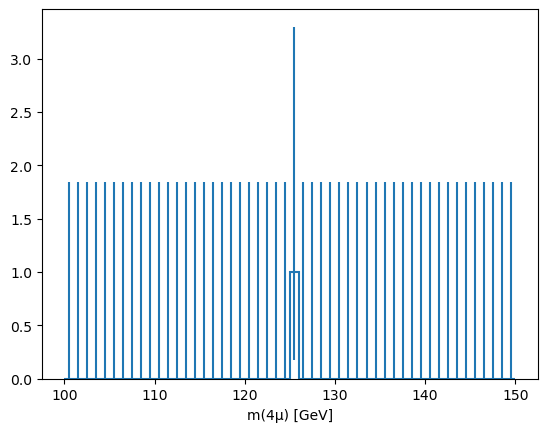

In [2]:
# Mini demo notebook for `get_hist` + `Fourleptons` + coffea runner

# --- Setup ---
import os
import numpy as np
import awkward as ak
import hist

from coffea import processor, util
from coffea.processor import Runner
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from dask.distributed import Client

# --- Minimal placeholders for plotting ---
class PlotProps:
    def __init__(self, bins, xmin, xmax, xlabel):
        self.bins = bins
        self.xmin = xmin
        self.xmax = xmax
        self.xlabel = xlabel

plot_props = {
    "fourmuons_mass": PlotProps(50, 100, 150, "m(4µ) [GeV]"),
    "selectedmuons_p": PlotProps(50, 0, 50, "p [GeV]"),
}

# Dummy req_hists just to satisfy get_hist
req_hists = {"dummy": None}

# --- get_hist function ---
def get_hist(name, var, process, flatten=False):
    props = plot_props[name]
    if flatten:
        var = ak.flatten(var, axis=None)
    var = var[~ak.is_none(var, axis=0)]
    if isinstance(var, ak.Array):
        var = ak.to_numpy(var)

    interactions = list(req_hists.keys())
    myhist = (
        hist.Hist.new
        .Reg(props.bins, props.xmin, props.xmax, name="observable", label=props.xlabel)
        .StrCat([], name="dataset", label="Dataset", growth=True)
        .Double()
    )
    for pro in interactions:
        myhist.fill(observable=var, dataset=name)
    return myhist

# --- Minimal Fourleptons processor ---
class Fourleptons(processor.ProcessorABC):
    def __init__(self, *args, **kwargs):
        pass

    def process(self, events):
        # Fake data: just two variables
        vars_sel = {
            0: {
                "selectedmuons_p": ak.Array([[5.0, 10.0, 12.0, 20.0]]),
                "fourmuons_mass": ak.Array([125.0]),
            }
        }

        Output = processor.dict_accumulator({
            "sel0": processor.dict_accumulator({
                "histograms": processor.dict_accumulator({
                    name: get_hist(name, var, process="dummy", flatten=True)
                    for name, var in vars_sel[0].items()
                }),
                "cutflow": processor.dict_accumulator({
                    "Onecut": 1,
                    "Cutflow": [1],
                    "Labels": ["No cut"],
                }),
            })
        })
        return Output

    def postprocess(self, accumulator):
        return accumulator

# --- Runner execution (with local dask) ---
# USE_DASK = True

# def filter_branches(branch_name: str) -> bool:
#     forbidden = ["PARAMETERS", "_intMap", "_floatMap", "_stringMap"]
#     return not any(substr in branch_name for substr in forbidden)

# if USE_DASK:
#     client = Client("tls://192.168.202.22:8786")
#     executor = processor.DaskExecutor(client=client, status=True)
# else:
#     executor = processor.FuturesExecutor(workers=1)

# runner = Runner(
#     executor=executor,
#     schema=NanoAODSchema,
#     savemetrics=True,
#     chunksize=1000,
# )

# # Fake fileset with empty NanoEvents (we won’t actually load files)
# fileset = [{"dummy_dataset": []}]

# output = runner(
#     fileset=fileset[0],
#     processor_instance=Fourleptons(),
#     treename="Events",
#     iteritems_options={"filter_name": filter_branches},
# )

# # --- Inspect results ---
# print("Histograms in output:", output["sel0"]["histograms"].keys())

# h_mass = output["sel0"]["histograms"]["fourmuons_mass"]
# print("fourmuons_mass hist entries:", h_mass.values())

# --- Manual execution with fake events instead of Runner ---
events = {
    "ReconstructedParticles": ak.Array([{"E": 50.0}]),
}

processor_instance = Fourleptons()
output = processor_instance.process(events)

# --- Inspect results ---
print("Histograms in output:", output["sel0"]["histograms"].keys())

h_mass = output["sel0"]["histograms"]["fourmuons_mass"]
print("fourmuons_mass hist entries:", h_mass.values())

# Optional: plot histogram
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
h_mass.plot(ax=ax)
plt.show()
